In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Objective
A key goal for CAPISH is to evaluate the fidelity of the confidence and credible intervals produced by \texttt{CAPISH-SBI}---that is, to ensure they are well-calibrated. This involves two steps: Bayesian calibration (credible intervals) and Frequentist calibration (confidence intervals).

### 1. Frequentist Calibration: Confidence Intervals
Let $\theta_0$ denote the true underlying cosmological parameter. Consider $D_k \sim P(D_k|\theta_0)$ as random samples generated from the model conditioned on $\theta_0$. Each $D_k$ yields a $\gamma$-level confidence interval $\widehat C^\gamma_k = \text{Conf}_\gamma(D_k)$, computed based on the likelihood (e.g., via MLE and the Fisher matrix). The objective is to verify whether the confidence intervals satisfy the condition:
$$
P(\theta_0 \in \text{Conf}_\gamma(D_k) \mid \theta_0) = \gamma 
$$
i.e., we want to measure how often the interval $\widehat C^\gamma_k$ (considered as a random variable) contains the true parameter $\theta_0$. This is the Frequentist calibration of the confidence intervals provided by our SBI code. 
We can average over $\theta_0$ over the prior
$$
E_{\theta_0}[P(\theta_0 \in \text{Conf}_\gamma(D_k) \mid \theta_0)] = \gamma 
$$
This is tipycally what we want to do. However, note that the confidence interval are difficult to assess in practice. This can be done with Fisher analysis, Likelihood profiling etc. 

### 2. Bayesian Calibration: Credible Intervals
Let $D_k$ denote some observed data, from which we derive the $\gamma$-credible interval $\widehat{C}^\gamma_k = \text{Cred}_\gamma(D_k)$ using Bayes' theorem. Bayesian calibration involves verifying that (Hugo: Pour toutes les cosmologies qui réalisent la même donnée, il faut vérifier que ces cosmologies tombent bien en proportion $\gamma$ dans l'intervalle de crédibilité $\gamma$)
$$
P(\theta \in \text{Cred}_\gamma(D_k) \mid D_k) = \gamma
$$
One can then average over the data $D_k$ using the likelihood evidence:
$$
E_{D_k}\left[P(\theta \in \text{Cred}_\gamma(D_k) \mid D_k)\right] = \gamma
$$
The above quantity (the left-hand side of the equation) is difficult to access in practice, as it requires binning over the data. It can be estimated using TARP, "Tests of Accuracy with Random Points" [https://arxiv.org/abs/2302.03026] by Lemos et al. (2023).

Since confidence intervals are often challenging to assess in practice, we instead aim to perform Frequentist-style calibration using Bayesian credible intervals. This approach is more straightforward to implement, but it requires that the resulting credible intervals are not overly sensitive to the choice of prior.

# Frequentist Calibration: To-do

Here below I details how it can be done. 

#### Procedure for a fixed confidence level $\gamma$:
- Generate $N$ simulations: $D_k \sim P(D \mid \theta_0)$ for $k = 1, \dots, N$.
- Estimate:
    $$
    p_\gamma^{\theta_0} = \frac{1}{N} \sum_{i=1}^N \mathbb{I}[\theta_0 \in \widehat C^\gamma_k],
    $$
which is the empirical coverage probability at $\theta_0$.

We can extend this to multiple cosmological parameters: sample $N_{\theta_0}$ values $\theta_0 \sim \pi(\theta_0)$. For each value of $\theta_0$, perform $N_{\theta_0}^{\rm sim}$ simulations. The total number of simulations is $N_{\theta_0}^{\rm sim} \times N_{\theta_0}$. Then compute:
$$
p_\gamma = \frac{1}{N_{\theta_0}} \sum_{\theta_0'}^{N_{\theta_0}} \frac{1}{N_{\theta_0}^{\rm sim}} \sum_{\rm sim}^{N_{\theta_0}^{\rm sim}} \mathbb{I}[\theta_0' \in \widehat C^\gamma_{\rm sim}] 
= \frac{1}{N_{\theta_0}} \sum_{\theta_0'}^{N_{\theta_0}} p_\gamma^{\theta_0}.
$$

# Frequentist Calibration: an exemple with credible intervals.

In practice:
- First, given a true parameter $\theta_0$ (prior fixed).
- For a given credible interval $\alpha \in [0, 1]$:
  - We make $N$ simulations. 
  - $C_\alpha = 0$
  - For each $k$-th simulation:
      - Let $\mathcal{P}(\theta|\mathcal{D}_k, \theta_0)$ be the parameter posterior of some data realisation $\mathcal{D}_k$ for the underlying parameter $\theta_0$
      - we compute the credible interval corresponding to the credibility level $\alpha$, e.g. $\mathcal{P}(\theta|\mathcal{D}_k, \theta_0) =\mathcal{N}(\theta|0, 1)$ then, considering $\alpha = 0.5$ we have $[\theta_1, \theta_2] = [-0.67, +0.67]$
      - If $\theta_0$ in $[\theta_1, \theta_2]$, $C_\alpha = C_\alpha + 1$
  - $C_\alpha = C_\alpha/N$
  - Do this for all $\alpha$ credible interval.

In [2]:
cred = 0.5 #%
lower_coverage = (1 - cred) / 2
upper_coverage = 1 - lower_coverage
ci_lower = norm.ppf(lower_coverage, loc=0, scale=1)
ci_upper = norm.ppf(upper_coverage, loc=0, scale=1)
print('for a credibility level of ', str(cred*100), '% the confidence interval is [', str(ci_lower), str(ci_upper), ']')

for a credibility level of  50.0 % the confidence interval is [ -0.6744897501960817 0.6744897501960817 ]


In [3]:
cred = 0.9 #%
lower_coverage = (1 - cred) / 2
upper_coverage = 1 - lower_coverage
ci_lower = norm.ppf(lower_coverage, loc=0, scale=1)
ci_upper = norm.ppf(upper_coverage, loc=0, scale=1)
print('for a credibility level of ', str(cred*100), '% the confidence interval is [', str(ci_lower), str(ci_upper), ']')

for a credibility level of  90.0 % the confidence interval is [ -1.6448536269514729 1.6448536269514722 ]


In [4]:
credibility_levels = np.linspace(0.05, 0.99, 20)
true_theta = 0
n_sim = 1000
def ecp_(sigma):
    ecp= []
    for cred in credibility_levels:
        lower_coverage = (1 - cred) / 2
        upper_coverage = 1 - lower_coverage
        count = 0
        
        for i in range(n_sim):
            # Simulate data from known model
            data = np.random.normal(loc=true_theta, scale=1, size=10)
            posterior_mean = np.mean(data)
            posterior_sd = 1 / np.sqrt(len(data))
            posterior_sd *= sigma
            
            ci_lower = norm.ppf(lower_coverage, loc=posterior_mean, scale=posterior_sd)
            ci_upper = norm.ppf(upper_coverage, loc=posterior_mean, scale=posterior_sd)
            
            if ci_lower <= true_theta <= ci_upper:
                count += 1
        
        ecp.append(count / n_sim)
    return ecp

In [5]:
ecp = ecp_(1)

In [6]:
ecp_over = ecp_(1.2)

In [7]:
ecp_under = ecp_(0.8)

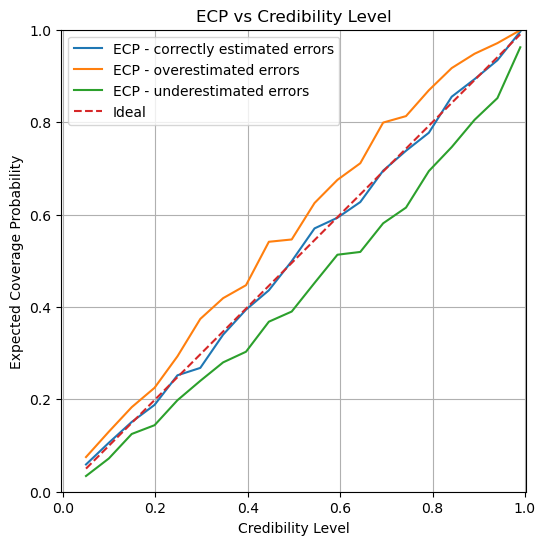

In [8]:
# Plot
plt.figure(figsize=(6, 6))
plt.axis('equal')
plt.plot(credibility_levels, ecp, label="ECP - correctly estimated errors")
plt.plot(credibility_levels,ecp_over, label="ECP - overestimated errors")
plt.plot(credibility_levels, ecp_under, label="ECP - underestimated errors")
plt.plot(credibility_levels, credibility_levels, '--', label="Ideal")
plt.xlabel("Credibility Level")
plt.ylabel("Expected Coverage Probability")
plt.title("ECP vs Credibility Level")
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()